In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import re
import pickle

np.random.seed(23)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
tw_df = pd.read_csv('./data/training.1600000.processed.noemoticon.csv', header=None, encoding='latin').drop(columns=[1, 2, 3, 4])
tw_df.columns = ['sentiment', 'text']

tw_df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


C:\Users\Nick\miniconda3\envs\stats304\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,sentiment
count,1600000.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.5
75%,1.0
max,1.0


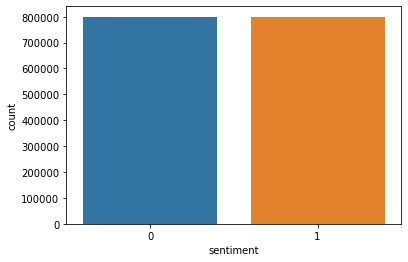

In [15]:
# standarize to 0-1
tw_df['sentiment'] = tw_df['sentiment'].apply(lambda val: 0 if val < 1 else 1)

sns.countplot(tw_df['sentiment'])
tw_df.describe()

In [26]:
vocab_size = 32000 # 15,000 most common words

emb_size = 100 # glove vectors are 100 dim

tweet_len = 40 # 40 tokens per tweet

In [32]:
# two stop words methods: NLTK list or TF1 specified below
# http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf

#stop_words = stopwords.words('english')

# stop words is the list of words that only occur once
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def tfi_stopwords(tw_df):
    stop_words = {""}
    seen_words = {""}
    for tweet in tw_df['text']:
        tweet = re.sub(text_cleaning_re, ' ', str(tweet).lower()).strip()
        for token in tweet.split():
            if token not in seen_words:
                if token in stop_words:
                    seen_words.add(token)
                    stop_words.remove(token)
                else:
                    stop_words.add(token)
    return stop_words

stop_words = tfi_stopwords(tw_df)

len(stop_words), len(stopwords.words('english'))

(214046, 179)

In [18]:
# Stemming may also hurt performance
# http://sentiment.christopherpotts.net/stemming.html

#stemmer = SnowballStemmer('english')
lemmatizer =  nltk.wordnet.WordNetLemmatizer()

In [19]:
# Removes ids and hyperlinks from tweets
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# Function applied to each tweet that uses stemmer, regex, and stopwords
def process_tweet(tweet):
    tweet = re.sub(text_cleaning_re, ' ', str(tweet).lower()).strip()
    tokens = []
    for token in tweet.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return ' '.join(tokens)

tw_df['text'] = tw_df['text'].apply(process_tweet)

In [20]:
train_df, test_df = train_test_split(tw_df, test_size=0.2, random_state=23)

In [21]:
# tokenize the tweets for the vocab size
tokenizer = Tokenizer(num_words=vocab_size, lower=True, oov_token='?')
tokenizer.fit_on_texts(train_df['text'])

# Save the tokenizer to be used to preprocess tweets later
pickle.dump(tokenizer, open("./FinalServer/MLDeploy/models/tokenizer.p", "wb"))

# Map of word-index pairs
word_index = tokenizer.word_index

# Standardize tweet length to tweet_len
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=tweet_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=tweet_len)

X_train.shape, X_test.shape, len(word_index)

((1280000, 40), (320000, 40), 249042)

In [10]:
y_train = train_df['sentiment']
y_test = test_df['sentiment']

y_train.shape, y_test.shape

((1280000,), (320000,))

In [11]:
# https://nlp.stanford.edu/projects/glove/
# a function to load vector model as dictionary
def load_glove_model(File):
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded")
    return glove_model

glove = load_glove_model('./data/glove.twitter.27B.100d.txt')

1193514 words loaded


In [12]:
len(word_index)

249042

In [13]:
# Create embedding layer for nn from word-index map and glove embeddings
embedding_matrix = np.zeros((vocab_size, emb_size))
for word, i in word_index.items():
  if i >= vocab_size:
    break
  embedding_vector = glove.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [14]:
# Implement LSTM Model
lstm_model = keras.models.Sequential()

embed_layer = keras.layers.Embedding(vocab_size, emb_size, weights=[embedding_matrix], input_length=tweet_len, trainable=False)
lstm_model.add(embed_layer)
lstm_model.add(keras.layers.SpatialDropout1D(0.10))
lstm_model.add(keras.layers.Conv1D(64, 5, activation='relu'))
lstm_model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
lstm_model.add(keras.layers.Dense(512, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.2))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# This model uses callbacks to save checkpoints, balance learning rate when validation loss plateaus and to stop early
callbacks = [keras.callbacks.ModelCheckpoint('./models', save_best_only=True),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 39)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 39, 100)           1500000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 39, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 64)            32064     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0   

In [15]:
history = lstm_model.fit(X_train, y_train, batch_size=512, epochs=8, validation_data=(X_test, y_test), callbacks=callbacks)
#lstm_model = keras.models.load_model('./FinalServer.MLDeploy/models/final_model.h5')
#lstm_model.save('./FinalServer/MLDeploy/models/final_model.h5')


Train on 1280000 samples, validate on 320000 samples
Epoch 1/8
1280000/1280000 [==============================] - 774s 605us/step - loss: 0.5225 - accuracy: 0.7367 - val_loss: 0.4885 - val_accuracy: 0.7617


PermissionError: [Errno 13] Unable to create file (unable to open file: name = './models/', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 302)

In [ ]:
# show the learning process
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_range = range(len(accuracy))

plt.figure(figsize=(10, 6))
plt.plot(epoch_range, accuracy, 'bo', label='Training')
plt.plot(epoch_range, val_accuracy, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epoch_range, loss, 'bo', label='Training')
plt.plot(epoch_range, val_loss, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.legend()
plt.show()

In [ ]:
# Use the model to predict the training samples 
y_pred = lstm_model.predict(X_train)

In [ ]:
# Convert probabilities into predictions
y_pred_ = np.round(y_pred)

# Plot the confusion matrix
cm1 = confusion_matrix(y_train, y_pred_)

plt.figure(figsize=(9,9))
sns.heatmap(cm1, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('true number', size=17)
plt.xlabel('predicted number', size=17)
plt.show()

accuracy_score(y_train, y_pred_)